# Technical Assessment - Matteo Cuvelier
*Interview of 12/09/2025*

## Description of the assignment
**The goal is to visualize and explore the price of real-estate sales in Belgium across time between 2010 and 2025.** The topic will be tackled as following:
- There will first be some data loading and preprocessing
- Then there will be a data exploration section
- Finally developments will be done over a price corrector and a price forecaster

## I - Data loading and preprocessing
The data represents the evolution of real estate sales (number and prices) over a period of 15 years, and is available here : https://statbel.fgov.be/en/themes/housing/real-estate#figures. The selected file is the one of `Sales of real estate (N) per quarter per municipality 2010-2025`.

Here we are going to import and preprocess the data.

In [ ]:
# I.1 - Import libraries
## Data manipulation
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd
import numpy as np

## Data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as ctx

## Forecasting
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [29]:
# I.2 - Load raw data
## Real estate data
immo_df = pd.read_excel('./data/FR_immo_statbel_trimestre_par_commune.xlsx', header=[1, 2])
## Geospatial data (communes)
immo_gdf = gpd.read_file('./data/sh_statbel_statistical_sectors_3812_20240101.geojson/sh_statbel_statistical_sectors_3812_20240101.geojson')

In [30]:

# I.3 - Data cleaning & preparation
## Data cleaning : correct data types, rename columns, drop unnecessary empty columns
immo_df = immo_df.rename(columns={'Unnamed: 0_level_0':'Général',
                                  'Unnamed: 1_level_0':'Général',
                                  'Unnamed: 2_level_0':'Général',
                                  'Unnamed: 3_level_0':'Général'}, level=0)
immo_df = immo_df.drop(columns=[('Unnamed: 4_level_0', 'période'),
                      ('Toutes les maisons avec 2, 3, 4 ou plus de façades (excl. appartements)', 'prix troisième quartile(€).1'),
                      ('Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)', 'prix troisième quartile(€).1'),
                      ('Maisons avec 4 ou plus de façades (type ouvert)', 'prix troisième quartile(€).1'),
                      ('Appartements', 'prix troisième quartile(€).1'),
                      ('Appartements', 'prix troisième quartile(€).2'),
                      ('Appartements', 'prix troisième quartile(€).3'),
                      ('Appartements', 0),])
immo_df[('Général', 'refnis')] = immo_df[('Général', 'refnis')].astype(int)

## Data preprocessing : reformat the quarter representation for further aggregations and representations
immo_df[('Général', 'période')] = immo_df[('Général', 'période')].apply(lambda x: int(x.replace('Q', '')))
immo_df[('Général', 'trimestre')] = pd.PeriodIndex.from_fields(year=immo_df[('Général', 'année')], quarter=immo_df[('Général', 'période')], freq="Q")

## Data preprocessing : merge geospatial data to the refnis level real estate data
immo_gdf = immo_gdf[['cd_munty_refnis', 'tx_adm_dstr_descr_fr', 'tx_rgn_descr_fr', 'geometry']]
immo_gdf = immo_gdf.dissolve(by=['cd_munty_refnis', 'tx_adm_dstr_descr_fr', 'tx_rgn_descr_fr'])
immo_gdf = immo_gdf.reset_index()
immo_gdf.columns = ['refnis', 'Arrondissement', 'Région', 'geometry']
immo_gdf['refnis'] = immo_gdf['refnis'].astype(int)

In [31]:
## I.4 - Data aggregation : national level
### Isolation of relevant columns names
immo_types = ['Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)',
              'Maisons avec 4 ou plus de façades (type ouvert)',
              'Appartements']
variables = ['nombre transactions', 'prix médian(€)', 'prix premier quartile(€)', 'prix troisième quartile(€)']

### Selecting the right columns and transforming the dataframe to a long format
aggregated_df = immo_df.copy()
dfs = []
for type in immo_types:
    cols = []
    for col in aggregated_df.columns:
        if col[0] in ['Général', type]:
            cols.append(col)
        tmp = aggregated_df[cols].copy()
        tmp[('Général', 'Type')] = type
        tmp.columns = [i[1] for i in tmp.columns.tolist()]
    dfs.append(tmp)
long_df = pd.concat(dfs)

### Compute "intermediate" totals = price indicator × number of transactions (to reconstruct a weighted average across communes)
long_df['computation_intermediate_median_price'] = long_df['prix médian(€)'] * long_df['nombre transactions']
long_df['computation_intermediate_q1_price'] = long_df['prix premier quartile(€)'] * long_df['nombre transactions']
long_df['computation_intermediate_q3_price'] = long_df['prix troisième quartile(€)'] * long_df['nombre transactions']

### Aggregate at national level per trimestre (sum of transactions and intermediates)
national_df = long_df.groupby(['trimestre']).sum().reset_index()[['trimestre', 'nombre transactions', 'computation_intermediate_median_price', 'computation_intermediate_q1_price', 'computation_intermediate_q3_price']]

### Keep only the total number of transactions (drop intermediate columns for now)
national_df = national_df.drop(columns=['computation_intermediate_median_price', 'computation_intermediate_q1_price', 'computation_intermediate_q3_price']) 
national_df = national_df.set_index('trimestre')

### Recompute national price indicators as weighted averages (intermediate sum / total N) (Drop NA rows first so averages aren't biased)
national_df_price = long_df.dropna().groupby(['trimestre']).sum().reset_index()[['trimestre', 'nombre transactions', 'computation_intermediate_median_price', 'computation_intermediate_q1_price', 'computation_intermediate_q3_price']]
national_df_price['prix médian(€)'] = national_df_price['computation_intermediate_median_price'] / national_df_price['nombre transactions']
national_df_price['prix premier quartile(€)'] = national_df_price['computation_intermediate_q1_price'] / national_df_price['nombre transactions']
national_df_price['prix troisième quartile(€)'] = national_df_price['computation_intermediate_q3_price'] / national_df_price['nombre transactions']

### Drop helper columns to keep only clean national indicators
national_df_price = national_df_price.drop(columns=['computation_intermediate_median_price', 'nombre transactions', 'computation_intermediate_q1_price', 'computation_intermediate_q3_price']) 
national_df_price = national_df_price.set_index('trimestre')

### Merge number of transactions (from national_df) with weighted prices (from national_df_price)
national_df = pd.concat([national_df, national_df_price], axis=1)
national_df = national_df.reset_index()

### Reset index and make 'trimestre' a proper datetime (end of quarter) for visulization purposes
national_df['trimestre'] = national_df['trimestre'].dt.to_timestamp(how="end")

### Build a table per commune for mapping purposes
commune_df = long_df[['refnis', 'nombre transactions']].groupby('refnis').sum().reset_index().copy()
commune_df = commune_df.merge(immo_gdf, left_on='refnis', right_on='refnis', how='left')

## II - Data exploration
The goal here is to **make a visualization to help explore the evolution of the number (N) of transactions and price (€)** of real estate sales. Then, perform some analysis to make sense of the produced visualization. The visualization will be done interactively. Then a mapped version of a visualization will be presented.

For that we will have a look at national level. We will show the evolution of the total number of transactions and median price overall. For the price we will filter the rows where there is price data and perform a weighted average based on the number of transactions.

In [47]:

# First: line plot for prices (median + Q1 + Q3)
fig = px.line(national_df, x="trimestre", y=["prix premier quartile(€)","prix médian(€)","prix troisième quartile(€)"], 
              labels={"value": "Prix (k€)", "variable": "Legend"},
              title="Real estate number of transactions and median prices (€, weighted average of medians) in Belgium",)

# Add filled envelope manually (Q1–Q3)
fig.add_traces([
    px.line(national_df, x="trimestre", y="prix premier quartile(€)").data[0],
])
fig.data[-1].line.color = "rgba(255,0,0,0)"
fig.data[-1].showlegend = False

# Use fill between Q3 and Q1
fig.add_traces([
    px.line(national_df, x="trimestre", y="prix troisième quartile(€)").data[0],
])
fig.data[-1].update(fill="tonexty", fillcolor="rgba(255,0,0,0.2)", line_color="rgba(255,0,0,0)", name="IQR")

# Transactions on secondary axis
fig.add_bar(x=national_df["trimestre"], y=national_df["nombre transactions"], name="Transactions", yaxis="y2", marker_color="royalblue", opacity=0.4)

# Set  axes
fig.update_layout(
    yaxis=dict(title="Price (€)"),
    yaxis2=dict(title="Transactions", overlaying="y", side="right"),
    xaxis=dict(title="Quarter"),
    legend=dict(x=0.01, y=0.99, bordercolor="LightGray", borderwidth=1)
)
fig.data[0].name = "Q1 (25th percentile)"
fig.data[1].name = "Median price"
fig.data[2].name = "Q3 (75th percentile)"
fig.data[-1].name = "Transaction number"   # the filled band

fig.show()

### Interpretation
With this visualization we can really dive into the price dynamics and transaction volumes of the real estate market in Belgium for the past 15 years.

The first, obvious, insight is a clear increase in median of the price in real estate from 175k€ to 309k€, and also we can notice an enlargement of the band between the first and third quartile, showing a bigger spread of the prices. This is especially true with the thrid quartile getting further to the median, showing an increase of proportion and price of the most expensive properties.

We can notice a drop in price in 2020 (for COVID) that then started a stronger increasing dynamic than previously.

In terms of volume we see a relative stability until 2020 where we see a drop and then a compensating increase. Overall we notice a small increase over time but with a quite slow trend.

There seems to be no direct relationship between price and volume of selling. Prices seem to follow a trend while sales are more related to externalities (like pandemics, economical crisis...)


### Perspectives, other relevant visualization
My goal here was to focus on a national overview but other visualizations could have been very telling to explore the structure of the real estate market in Belgium. Similar representations per region or per type of property could have raised other insights on the discrepancies in the market. 

In terms of interactiveness some solutions could be to use dash web apps or just some sliders and drop down menus in plotly, depending on the need.

Now let's visualize on a map the total number of sales between 2010 and 2025 per commune.

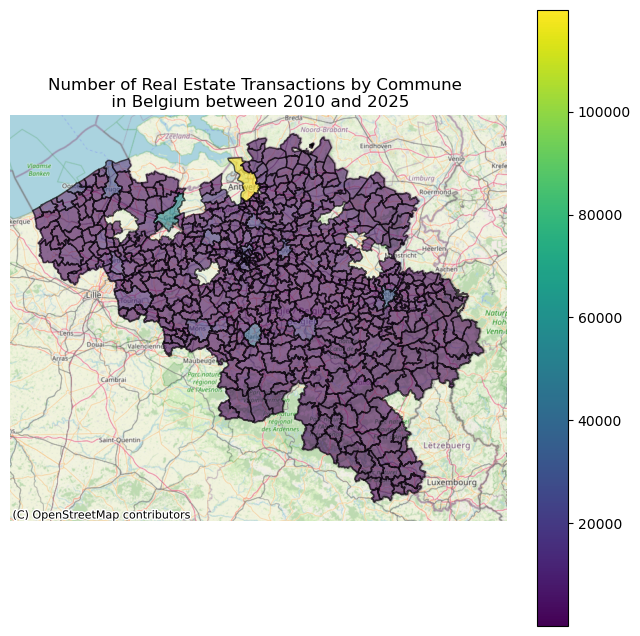

In [ ]:
# Reproject in a referential corresponding to the web maps
commune_df = gpd.GeoDataFrame(commune_df).to_crs(epsg=3857)

# Plot data
ax = commune_df.plot(
    column="nombre transactions",  # color by this column
    cmap="viridis",
    legend=True,
    figsize=(8, 8),
    alpha=0.6,              # transparency so basemap shows
    edgecolor="black"
)

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # or OSM, Stamen, etc.

# Set axis and title
ax.set_title("Number of Real Estate Transactions by Commune \n in Belgium between 2010 and 2025")
ax.set_axis_off()
plt.show()

## III - Price Corrector

The goal is to build a "price corrector" that takes as input a listing price at time t0, the municipality code (refnis) and the type of property, and predicts the price at another time t1, only using the time range available in the dataset in this part.

In [ ]:
def price_corrector(refnis: int, listing_price: int, type: str, t0, t1, long_df=long_df):
    """
    Predict the price of a listing at time t1 based on its price at time t0, the municipality code (refnis), and the type of property.
    The function uses historical median prices to compute a price change factor between t0 and t1 for the given refnis and type.

    Parameters:
    - refnis (int): Municipality code.
    - listing_price (int): Listing price at time t0.
    - type (str): Type of property (e.g., 'Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)', 'Maisons avec 4 ou plus de façades (type ouvert)', 'Appartements').
    - t0 (str or pd.Period): Initial time point in 'YYYYQ#' format or as a pd.Period object.
    - t1 (str or pd.Period): Target time point in 'YYYYQ#' format or as a pd.Period object.
    - long_df (pd.DataFrame): DataFrame containing historical real estate data in long format
    
    Returns:
    - predicted_price_t1 (float): Predicted listing price at time t1.
    """
    
    # Filter the dataframe for the given refnis and type of property
    df_filtered = long_df[(long_df['refnis'] == refnis) & (long_df['Type'] == type)]

    # Ensure t0 and t1 are in Period format (quarter)
    if not isinstance(t0, pd.Period):
        t0 = pd.Period(t0, freq='Q')
    if not isinstance(t1, pd.Period):
        t1 = pd.Period(t1, freq='Q')
    
    # Check if t0 and t1 are within the range of available data
    available_quarters = df_filtered['trimestre'].unique()
    if t0 not in available_quarters or t1 not in available_quarters:
        raise ValueError("t0 and t1 must be within the range of available data.")
    
    # Check is we have price data for the given refnis and type at both dates
    if df_filtered[(df_filtered['trimestre'] == t0) & (df_filtered['prix médian(€)'].notna())].empty or \
       df_filtered[(df_filtered['trimestre'] == t1) & (df_filtered['prix médian(€)'].notna())].empty:
        raise ValueError("Price data not available for the given refnis, type, or time points.")

    # Get the median prices at t0 and t1
    price_t0 = df_filtered[df_filtered['trimestre'] == t0]['prix médian(€)'].values
    price_t1 = df_filtered[df_filtered['trimestre'] == t1]['prix médian(€)'].values
    
    # Calculate the price change factor
    price_change_factor = price_t1[0] / price_t0[0]
    
    # Predict the new listing price at t1
    predicted_price_t1 = listing_price * price_change_factor
    
    return predicted_price_t1

In [ ]:
# Let's test the function with an example
price_corrector(refnis=21004, listing_price=300000, type='Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)', t0='2020Q1', t1='2023Q1')

np.float64(323513.51351351355)

**Bonus question: Can you forecast the price for future quarter(s) not provided in the dataset?
To do that I would implement a time series forecast model.**

In [ ]:
# Example with still the refnis=21004 and for a type='Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)'
forecast_example_series = long_df[(long_df['refnis'] == 21004) & (long_df['Type'] == 'Maisons avec 2 ou 3 façades (type fermé + type demi-fermé)')][['trimestre', 'prix médian(€)']]
forecast_example_series['trimestre'] = forecast_example_series['trimestre'].dt.to_timestamp(how="end")
forecast_example_series = forecast_example_series.set_index('trimestre')
y = forecast_example_series['prix médian(€)']

The idea here is to fit a simplisitic model to hava a rough estimation of the median price for the selected case after the end of the available data. The Exponential smoothing is voluntarily chosen for its simplicity. With more time to work on and tune a model, it would have been interesting to go for some statistical approaches (ARIMA-like) or machine learning (typically Random Forest).

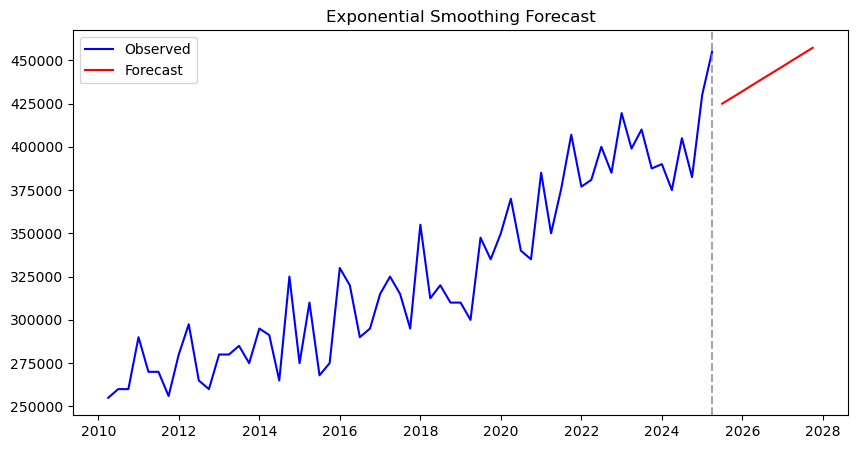

In [99]:
# Fit Exponential Smoothing (trend only, no seasonality)
model = ExponentialSmoothing(y, trend="add", seasonal=None)
fit = model.fit()

# Forecast next 10 periods
n_forecast = 10
forecast = fit.forecast(n_forecast)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y, label="Observed", color="blue")
plt.plot(forecast, label="Forecast", color="red")
plt.axvline(y.index[-1], color="gray", linestyle="--", alpha=0.7)  # separator
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.show()


Now that we have the forecast we can just input the concatenation of the forecasted value and historical value in the price corrector to get the price of the property in the future.

This forecast is obviously simplistic but can give a rough idea of the trend of the future.